In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from utilities import retrieve_data, cumulative_days_in_months
import calendar
from matplotlib.colors import ListedColormap, BoundaryNorm

ERA_VERSION = 'ERA5'  # One day this will change to ERA6

# ====================
# To get a CDS API key, sign up at https://cds.climate.copernicus.eu/
# It is free and easy! After registering, copy your "Personal Access Token here"
# ====================
KEY = '############################'
KEY = '6cc2b53b-e3c0-42fd-b7ad-db64aeeb5298'
KEY = '8f3ee43a-fa64-4eb9-a403-6567171bb625'

# ====================
# Change these to plot different locations. You can see the currently used ones in the ERA Explorer URL
# ====================
lat = 50.86  # Default latitude
lng = 4.35  # Default longitude

# ====================
# These can be changed to get different data; leave them for now
# ====================
variable = "10m_u_component_of_wind"
date_range = ["1991-01-01", "2020-12-31"]

# ====================
# Get the data. This will download a NetCDF file
# ====================
data_file = retrieve_data(KEY, variable, date_range, lat, lng)

# ====================
# To calculate relative humidity we need dewpoint temperature as well
# ====================
variable2 = "10m_v_component_of_wind"
data_file2 = retrieve_data(KEY, variable2, date_range, lat, lng)

{'variable': ['10m_u_component_of_wind'], 'date': ['1991-01-01/2020-12-31'], 'location': {'longitude': 4.35, 'latitude': 50.86}, 'data_format': 'netcdf'}
10m_u_component_of_wind_1991-01-01_2020-12-31_50.86_4.35.nc


2024-12-04 13:33:56,195 INFO [2024-07-18T00:00:00] Remember that you need to have an ECMWF account to use CDS-Beta. **Your existing CDS credentials will not work in CDS-Beta!**
2024-12-04 13:33:56,199 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2024-12-04 13:33:56,204 WARNING [2024-06-16T00:00:00] Check our [informative page](https://confluence.ecmwf.int/x/uINmFw) to best prepare yourself to use CDS-Beta.
2024-12-04 13:33:56,217 WARNING [2024-06-16T00:00:00] **BETA version** of the new CDS. Your [feedback](https://jira.ecmwf.int/plugins/servlet/desk/portal/1/create/202) is very useful for us. **Please notice** that access to the system might suffer some disruptions due to evolving updates.
2024-12-04 13:33:56,498 INFO Request ID is fc49317f-c793-409b-b673-e9

Retrieving data in to:  10m_u_component_of_wind_1991-01-01_2020-12-31_50.86_4.35.nc
{'variable': ['10m_v_component_of_wind'], 'date': ['1991-01-01/2020-12-31'], 'location': {'longitude': 4.35, 'latitude': 50.86}, 'data_format': 'netcdf'}
10m_v_component_of_wind_1991-01-01_2020-12-31_50.86_4.35.nc


2024-12-04 13:34:00,956 INFO Request ID is d7de13df-4ba3-41a0-9fd4-4f9121527f80
2024-12-04 13:34:01,114 INFO status has been updated to accepted
2024-12-04 13:34:02,189 INFO status has been updated to running
2024-12-04 13:34:03,780 INFO status has been updated to successful
                                                                                         

Retrieving data in to:  10m_v_component_of_wind_1991-01-01_2020-12-31_50.86_4.35.nc


In [2]:

# Define a function to bin angles into 45-degree chunks with an offset of -22.5 degrees
def bin_angle(angle, nbins=8):
    """
    Bin an angle into one of the specified number of bins.
    Parameters:
    angle (float): The angle in degrees to be binned.
    nbins (int): The number of bins to divide the 360 degrees into. Default is 8.
    Returns:
    str: The label of the bin into which the angle falls, formatted as 'start to end' degrees.
    Example:
    >>> bin_angle(45, 8)
    '22.5 to 67.5'
    """
    
    angle = angle % 360
    width = 360 / nbins
    offset = width / 2
    adjusted_angle = (angle + offset) % 360
    bin_index = int(np.floor(adjusted_angle / width))
    bin_labels = ['{:.1f} to {:.1f}'.format(i * width - offset, i * width + offset) for i in range(nbins)]
    return bin_labels[bin_index]


# Define a function to calculate wind magnitude
def calculate_magnitude(u, v):
    """
    Calculate the magnitude of a vector given its u and v components.
    Parameters:
    u (array-like): The u component of the vector.
    v (array-like): The v component of the vector.
    Returns:
    numpy.ndarray: The magnitude of the vector.
    """

    return np.sqrt(u ** 2 + v ** 2)

# Define a function to bin magnitudes into categories
def bin_magnitude(magnitude, cutoffs):
    """
    Categorizes a given magnitude into a bin based on provided cutoff values.
    Parameters:
    magnitude (float): The magnitude value to be categorized.
    cutoffs (list of int): A list of cutoff values that define the bins. 
                           The list should have exactly 4 elements.
    Returns:
    str: A string representing the bin in which the magnitude falls. 
         The format will be one of the following:
         - '< X' if the magnitude is less than the first cutoff.
         - 'X-Y' if the magnitude falls between two cutoffs.
         - 'Y+' if the magnitude is greater than or equal to the last cutoff.
    """
    
    if magnitude < cutoffs[1]:
        if cutoffs[0] == 0:
            return '< {:d}'.format(cutoffs[1])
        else:
            return '{:d}-{:d}'.format(cutoffs[0], cutoffs[1])
    elif magnitude < cutoffs[2]:
        return '{:d}-{:d}'.format(cutoffs[1], cutoffs[2])
    elif magnitude < cutoffs[3]:
        return '{:d}-{:d}'.format(cutoffs[2], cutoffs[3])
    else:
        return '{:d}+'.format(cutoffs[3])
    
# Make a function to compute the wind climatology
def windMonthlyClimatology():
    """
    Calculate the monthly climatology of wind direction and magnitude.
    This function reads wind data from two NetCDF files, calculates the wind direction
    angle and magnitude, bins the data into specified angle and magnitude bins, and 
    returns the percentage of occurrences in each bin.
    Returns:
        bin_percentages (pd.DataFrame): A DataFrame containing the percentage of occurrences 
                                        in each angle and magnitude bin.
        angle_bins (list): A list of angle bin labels.
        cutoff_labels (list): A list of magnitude bin labels.
    """

    data_u10_pt = xr.open_dataset(data_file).u10
    data_v10_pt = xr.open_dataset(data_file2).v10

    # Convert xarray DataArrays to pandas Series
    u_series = data_u10_pt.to_series()
    v_series = data_v10_pt.to_series()

    # Calculate wind direction angle
    # Angle is calculated as arctan2(-u, -v) and converted from radians to degrees
    # Note: -u and -v are used because the angle is usually measured from the north direction.
    angle = np.arctan2(-u_series, -v_series) * (180 / np.pi)

    # Create a DataFrame with time and angle
    df = pd.DataFrame({
        'u': u_series,
        'v': v_series,
        'Time': u_series.index,
        'Angle': angle
    })

    # Optionally, you can sort by time if needed
    df.sort_values('Time', inplace=True)

    # Calculate wind magnitude and add to DataFrame
    df['Magnitude'] = calculate_magnitude(df['u'], df['v'])

    # Apply the angle binning function
    df['Angle Bin'] = df['Angle'].apply(lambda x: bin_angle(x, 16))

    # Apply the magnitude binning function
    nearest_even = int(np.round(df['Magnitude'].median() / 2) * 2)
    cutoffs = [0, int(nearest_even / 2), nearest_even, int(nearest_even * 1.5)]
    df['Magnitude Bin'] = df['Magnitude'].apply(lambda x: bin_magnitude(x, cutoffs))

    # df.sort_values(by='Angle Bin', inplace=True)
    df.sort_index(inplace=True)

    # Count occurrences in each angle bin and magnitude bin
    bin_counts = df.groupby(['Angle Bin', 'Magnitude Bin']).size().unstack(fill_value=0)
    bin_percentages = 100 * bin_counts / bin_counts.sum(axis=1).sum(axis=0)

    angle_bins = [bin_angle(i * 360 / 16, 16) for i in range(16)]

    bin_percentages.index = pd.CategoricalIndex(bin_percentages.index, categories=angle_bins, ordered=True)
    bin_percentages.sort_index(inplace=True)

    # Define the desired column order
    cutoff_labels = [bin_magnitude(cutoffs[i], cutoffs) for i in range(len(cutoffs))]

    # Reindex columns to the desired order
    bin_percentages = bin_percentages.reindex(columns=cutoff_labels)

    angle_bins = [bin_angle(i * 360 / 16, 16) for i in range(16)]
    cutoff_labels = [bin_magnitude(cutoffs[i], cutoffs) for i in range(len(cutoffs))]

    return bin_percentages, angle_bins, cutoff_labels

# Call our function
bin_percentages, angle_bins, cutoff_labels = windMonthlyClimatology()

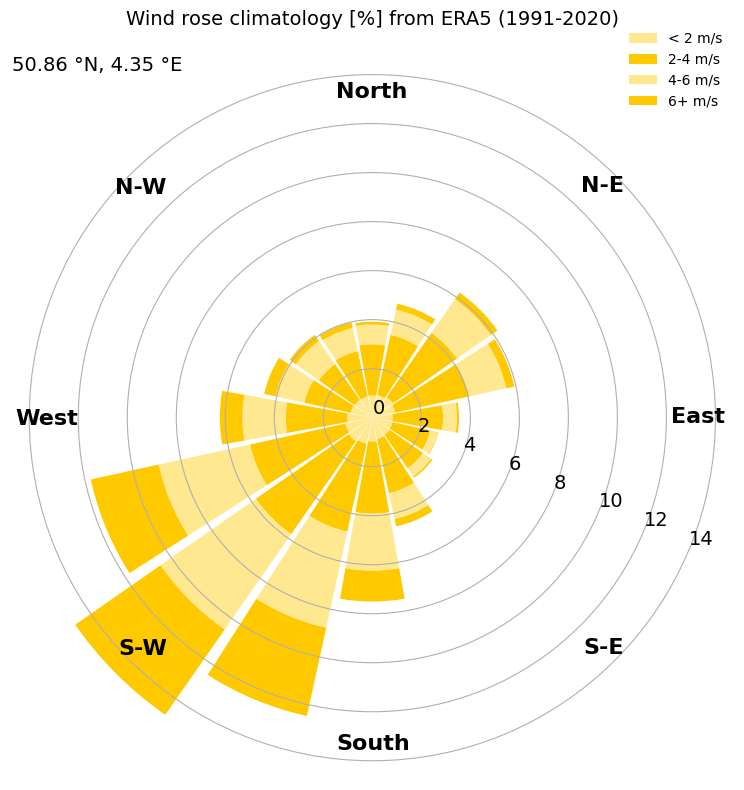

In [3]:
latSuffix = 'N' if lat > 0 else 'S'
lngSuffix = 'E' if lng > 0 else 'W'

month_names = [calendar.month_abbr[i] for i in range(1, 13)]

# Custom colors
dailyPolarColors = [
    "#0055ff", "#4376ce", "#859bb4", "#b1bab8", "#d3d7b2",
    "#f2eaa3", "#fff29e", "#fee996", "#fed383", "#ffb369",
    "#ff8949", "#ff4e21", "#ff0000"
]

direction_labels = ['North', 'N-E', 'East', 'S-E', 'South', 'S-W', 'West', 'N-W']

nbins = bin_percentages.shape[0]
width = 0.9 * 2 * np.pi / nbins

# Convert month to radians for the polar plot
angles = np.linspace(0, 2 * np.pi, nbins, endpoint=False) - np.pi / 2

cumul_bin_percentages = bin_percentages.sum(axis=1).values

ylim1 = max(cumul_bin_percentages)

colors = ['#FFE88F', '#FFC900', '#FFE88F', '#FFC900']

# Create the plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'polar'})
ax.set_frame_on(False)

# Set the direction to clockwise
ax.set_theta_direction(-1)

ax.set_ylim(0, ylim1)

# Add labels
ax.set_xticks([])
ax.set_yticks(range(0, int(max(cumul_bin_percentages)) + 2, 2))
ax.tick_params(axis='y', labelsize=14)

# Shade alternate segments (30 degrees wide) with curved edges
for (index, angle) in enumerate(np.arange(0, 360, 45)):  # 360 degrees, step of 30 degrees
    # Start and end angles for each segment (in radians)
    mid_angle = np.deg2rad(angle)
    start_angle = mid_angle - np.deg2rad(width / 2)

    # Add the month label inside the shaded segment
    ax.text(start_angle - np.pi / 2, 0.9 * ylim1,
            direction_labels[index], horizontalalignment='center',
            verticalalignment='center', fontsize=16, fontweight='bold')

# Plot each segment as a stacked bar (4 segments per bar)
for i, col in enumerate(bin_percentages.columns):  # Loop over the 4 columns (angle bins)
    ax.bar(angles, bin_percentages[col], width=width, 
           bottom=bin_percentages.iloc[:, :i].sum(axis=1), 
           color=colors[i], linewidth=1,
           label=f'{cutoff_labels[i]} m/s')

# Add legend and title
ax.legend(loc='upper right', bbox_to_anchor=(1, 1.05), framealpha=0)
plt.title(f'Wind rose climatology [%] from {ERA_VERSION} ({date_range[0][:4]}-{date_range[1][:4]})\n', fontsize=14)

# Add text in figure coordinates (x=0, y=1 is top-center of the figure)
fig.text(0.05, 0.9, f'{abs(lat):.2f} °{latSuffix:s}, {abs(lng):.2f} °{lngSuffix:s}',
         ha='left', va='bottom', fontsize=14)

plt.tight_layout()
plt.show()